In [2]:
%reload_ext autoreload

from glob import glob
import pandas as pd
import numpy as np
import xarray as xr
import holoviews as hv
import hvplot.pandas, hvplot.xarray

from lib.preamble import *

hv.extension('bokeh', width=1200)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from lib.preamble import *

paths = glob("../data/2023-10-*/d*.asc")
paths += glob("../data/2023-11-*/d*.asc")

def load_file(p):
	data = np.loadtxt(p)
	wavelength = data[:,0]
	counts = data[:,1]
	metadata = extract_metadata(p)
	if "capture" in metadata and metadata["capture"] is not None:
		number = int(metadata["capture"].split("x")[0])
		exposure = float(metadata["capture"].split("x")[1].split("s")[0])
		metadata = {**metadata, "number": number, "exposure": exposure}
		counts = counts / exposure / number
	
	return xr.DataArray(
		data=counts,
		coords={"wavelength": wavelength},
		attrs=metadata,
		name=metadata["name"],
	)

def custom_load(p):
	try: return load_file(p)
	except ValueError:
		print(f"Could not load {p}")
		return None

data = [custom_load(p) for p in paths]
data = [d for d in data if d is not None]

# add energy axis
for d in data: d.coords["energy"] = 1239.84193 / d.coords["wavelength"]

Could not load ../data/2023-11-30/d004_bcg_5x60s.asc
Could not load ../data/2023-11-30/d002_bcg_5x20s.asc
Could not load ../data/2023-11-29/d003_flake05_PL_exc_647nm_1_5mW_2x10s_10K_0T.asc
Could not load ../data/2023-11-29/d001_PL_exc_647nm_1_3mW_5x20s_10K_0T.asc
Could not load ../data/2023-11-29/d002_flake05_PL_exc_647nm_0_75mW_2x10s_10K_0T.asc
Could not load ../data/2023-11-29/d004_flake05_PL_exc_647nm_0_37mW_2x10s_10K_0T.asc


# Preliminary analysis

In [3]:
s = [ d for d in data if d.material == "CrPS4"]
# sel = data

hv.Layout([
	hv.Overlay([d.hvplot(label=d.name) for d in s if d.method == "luminescence"]),
	hv.Overlay([d.hvplot(label=d.name) for d in s if d.method == "reflectance"])
]).cols(1).opts(show_legends=False)

ValueError: cannot convert float NaN to integer

In [ ]:
s = [ d for d in data]
s = [d for d in data if "-27" in d.path]
# sel = [d for d in data if d.material == "NiPS3"]

on = [d for d in s if "on" in d.name and d.method=="reflectance"]
off = [d for d in s if "off" in d.name and d.method=="reflectance"]
refl = []
for on_i, off_i in product(on, off):
	if on_i is off_i: continue
	if on_i.capture != off_i.capture: continue
	if on_i.experiment != off_i.experiment: continue
	off_interp = off_i.interp(wavelength=on_i.wavelength)
	tmp = (on_i-off_interp)/off_interp # like: Structural and Optical Properties of Single and Few-Layer Magnetic Semiconductor CrPS4
	tmp.name = f"{on_i.name} / \n{off_i.name}"
	tmp.attrs = on_i.attrs
	refl.append(tmp)

hv.Layout([
	hv.Overlay([d.hvplot() for d in refl]).opts(
		ylabel="Reflectance",
	),
	hv.Overlay(
		[d.hvplot() for d in on]+\
		[d.hvplot(line_dash="dashed") for d in off],
	).opts(
		ylabel="Measured Reflectance spectra",
	),
]).cols(1)

:Layout
   .Overlay.I  :Overlay
      .Curve.I   :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample2.asc / 
2023-11-27/d001_NiPS3_3x10s_refl_off-sample.asc)
      .Curve.II  :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample.asc / 
2023-11-27/d001_NiPS3_3x10s_refl_off-sample.asc)
      .Curve.III :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-sample.asc / 
2023-11-27/d001_NiPS3_3x10s_refl_off-sample.asc)
   .Overlay.II :Overlay
      .Curve.I   :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample2.asc)
      .Curve.II  :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample.asc)
      .Curve.III :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_on-sample.asc)
      .Curve.IV  :Curve   [wavelength]   (2023-11-27/d001_NiPS3_3x10s_refl_off-sample.asc)

In [ ]:
# filter the refl
# convert refl from wavelength to wavenumber
thicknesses = np.geomspace(100, 10e3, 1000)
thick_signal = [(d.name, calc_thickness(d.wavelength, d.data, thicknesses)) for d in data if "-27" in d.path]
thick_signal = [
	xr.DataArray(
		data=d,
		coords={"thickness": thicknesses},
		name=n
	)
	for n,d in thick_signal
]

hv.Layout([
	hv.Overlay([
		((d/d.max()) **2).hvplot(logx=True)
		 for d in thick_signal]),
]).cols(1)

:Layout
   .Overlay.I :Overlay
      .Curve.I   :Curve   [thickness]   (2023-11-27/d001_NiPS3_3x10s_refl_off-sample.asc)
      .Curve.II  :Curve   [thickness]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample2.asc)
      .Curve.III :Curve   [thickness]   (2023-11-27/d001_NiPS3_3x10s_refl_on-different-sample.asc)
      .Curve.IV  :Curve   [thickness]   (2023-11-27/d001_NiPS3_3x10s_refl_on-sample.asc)

In [ ]:
# filter the low frequencies

In [ ]:
s = [ d for d in data]
s = [d for d in data if "-27" in d.path]

on_i = [d for d in s if "on" in d.name and d.method=="reflectance"]
off_i = [d for d in s if "off" in d.name and d.method=="reflectance"]
refl = []
for on_i, off_i in product(on_i, off_i):
	if on_i is off_i: continue
	if on_i.capture != off_i.capture: continue
	if on_i.experiment != off_i.experiment: continue
	off_interp = off_i.interp(wavelength=on_i.wavelength)
	tmp = (on_i-off_interp)/off_interp # like: Structural and Optical Properties of Single and Few-Layer Magnetic Semiconductor CrPS4
	tmp.name = f"{on_i.name} / \n{off_i.name}"
	tmp.attrs = on_i.attrs
	refl.append(tmp)
groups = groupby_list(refl, lambda d: d.material)


# (
# 	hv.Overlay([d.hvplot(label=d.name) for d in refl]) *
# 	hv.HLine(1).opts(color="black", line_width=1)
# ).opts(show_legend=False, )

hv.Layout(
	[
	(hv.Overlay([
		d.hvplot(label=d.name)
		for d in refl
	])*hv.HLine(0).opts(color="black", line_width=1)).opts(
		title=m,
		# height=150,
		show_legend=False,
		ylabel="Reflectance",
	)
	for m, refl in groups
]).cols(1)

ValueError: too many values to unpack (expected 2)

In [ ]:
set([d.name.split(":")[0] for d in data])

{'d001_01',
 'd001_02_cosmicRayRemoval',
 'd001_10x10s_NiPS_lm_0',
 'd001_CrPS_lm_532nm_2',
 'd001_CrPS_lm_685nm_2',
 'd001_MnPS3_REF_2x1s_20K',
 'd001_NiPS3_10K_refl_2x5s',
 'd001_NiPS3_10K_refl_2x5s_differentspot',
 'd001_NiPS3_20K_refl_2x5s',
 'd001_NiPS3_3x10s_refl_off-sample',
 'd001_NiPS3_3x10s_refl_on-different-sample',
 'd001_NiPS3_3x10s_refl_on-different-sample2',
 'd001_NiPS3_3x10s_refl_on-sample',
 'd001_NiPS3_refl-lm_1',
 'd001_NiPS3_refl-lm_18mW_onSample',
 'd001_NiPS3_refl_onSample',
 'd001_copper',
 'd001_mirror_2x5s',
 'd002_10x10s_NiPS_lm_0',
 'd002_FePS_refl_offSampleasc_5x5s',
 'd002_FePS_refl_onSampleasc_5x5s',
 'd002_mirror_2x5s',
 'd002_offSample_glass',
 'd003_10x10s_NiPS_refl_dark',
 'd003_10x10s_NiPS_refl_offSample',
 'd003_10x10s_NiPS_refl_onSample',
 'd003_NiPS3_REF_2x1s_20K',
 'd003_mirror_2x5s_defocused',
 'd003_refl_onFlake_NiPS3',
 'd004_2x10s_CrPS_lm_offSample',
 'd004_2x10s_CrPS_lm_onSample',
 'd004_5x10s_CrPS_lm_onSample',
 'd004_FePS3_REF_2x1s_20K',
 

In [4]:
def convert_to_energy(arr: xr.DataArray) -> xr.DataArray:
	"""Converts coord wavelength to energy"""
	arr = arr.copy()
	arr = arr.rename({'wavelength': 'energy'})
	arr['energy'] = 1239 / arr['energy']
	arr['energy'].attrs['units'] = 'eV'
	return arr

In [ ]:
# plot photo luminescence for all materials
s = [ d for d in data if d.method == "luminescence" and d.material and "PS" in d.material]
groups = groupby_list(s, lambda d:  d.material)
plot = hv.Layout([
	hv.Overlay([
		(d).hvplot(label=d.name) 
		for d in g
	]).opts(
		title=k, ylabel="PL",
		show_legend=False,
		height=200,
	)
	for k,g in groups
]).cols(1).opts(title="Photo Luminescence")
# hv.save(plot, "../figures/2023-11-08_PL.png")
plot

:Layout
   .Overlay.I   :Overlay
      .Curve.D013_CrPS4_10K_lm_2x2s       :Curve   [wavelength]   (d013_CrPS4_10K_lm_2x2s)
      .Curve.D004_2x10s_CrPS_lm_offSample :Curve   [wavelength]   (d004_2x10s_CrPS_lm_offSample)
      .Curve.D004_5x10s_CrPS_lm_onSample  :Curve   [wavelength]   (d004_5x10s_CrPS_lm_onSample)
      .Curve.D004_2x10s_CrPS_lm_onSample  :Curve   [wavelength]   (d004_2x10s_CrPS_lm_onSample)
      .Curve.D001_CrPS_lm_532nm_2         :Curve   [wavelength]   (d001_CrPS_lm_532nm_2)
      .Curve.D001_CrPS_lm_685nm_2         :Curve   [wavelength]   (d001_CrPS_lm_685nm_2)
   .Overlay.II  :Overlay
      .Curve.D014_FePS3_10K_lm_2x2s  :Curve   [wavelength]   (d014_FePS3_10K_lm_2x2s)
      .Curve.D010_FePS_lm_515nm_1.I  :Curve   [wavelength]   (d010_FePS_lm_515nm_1)
      .Curve.D010_FePS_lm_515nm_1.II :Curve   [wavelength]   (d010_FePS_lm_515nm_1)
      .Curve.D010_FePS_lm_532nm_2.I  :Curve   [wavelength]   (d010_FePS_lm_532nm_2)
      .Curve.D010_FePS_lm_532nm_2.II :Curve   [wavelength]   (d010_FePS_lm_532nm_2)
   .Overlay.III :Overlay
      .Curve.D012_MnPS3_10K_lm_2x1s                           :Curve   [wavelength]   (d012_MnPS3_10K_lm_2x1s)
      .Curve.D005_MnPS_lm_onSample_10x10s_532nm_2             :Curve   [wavelength]   (d005_MnPS_lm_onSample_10x10s_532nm_2)
      .Curve.D005_MnPS_lm_onSample_differentSpot_3x5_532nm_2  :Curve   [wavelength]   (d005_MnPS_lm_onSample_differentSpot_3x5_532nm_2)
      .Curve.D005_MnPS_lm_offSample_differentSpot_3x5_532nm_2 :Curve   [wavelength]   (d005_MnPS_lm_offSample_differentSpot_3x5_532nm_2)
      .Curve.D005_MnPS_lm_offSample_10x10s_532nm_2            :Curve   [wavelength]   (d005_MnPS_lm_offSample_10x10s_532nm_2)
      .Curve.D005_MnPS_lm_onSample_3x5_532nm_2                :Curve   [wavelength]   (d005_MnPS_lm_onSample_3x5_532nm_2)
   .Overlay.IV  :Overlay
      .Curve.D008_NiPS3_10K_lm_2x2s :Curve   [wavelength]   (d008_NiPS3_10K_lm_2x2s)
      .Curve.D010_NiPS3_10K_lm_2x2s :Curve   [wavelength]   (d010_NiPS3_10K_lm_2x2s)
      .Curve.D001_10x10s_NiPS_lm_0  :Curve   [wavelength]   (d001_10x10s_NiPS_lm_0)
      .Curve.D002_10x10s_NiPS_lm_0  :Curve   [wavelength]   (d002_10x10s_NiPS_lm_0)

In [ ]:
(4534-4350)/(49-11)

4.842105263157895

# Figures for Report

In [ ]:
set([d.method for d in data])

{None, 'luminescence', 'reflectance'}

## PL

In [ ]:
import lib.plot as plot

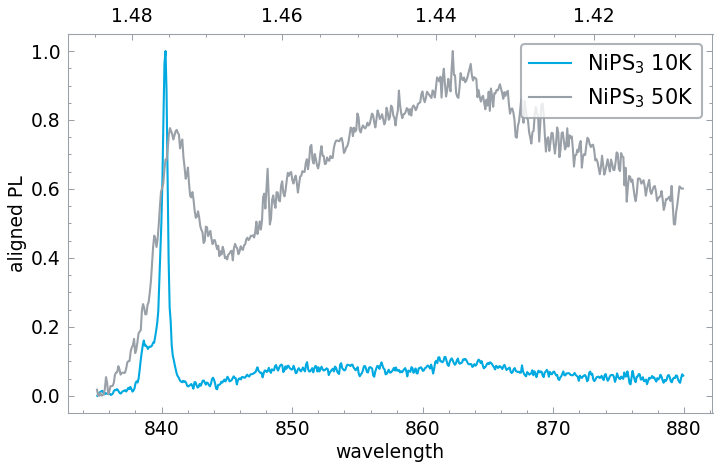

In [5]:
plt.figure()

sel = [d for d in data if d.material == "NiPS3" and d.method == "luminescence" and "off" not in d.name]
sel = np.array(sel, dtype="object")[[1, 3]]

for d in sel:
	s = d.sel(wavelength=slice(835, 880))
	(
		# (s - s.min())/(s - s.min()).interp(wavelength=865)
		(s - s.min())/(s - s.min()).max()
	).plot(
		label=d.name
	)
plt.legend(
	[r"NiPS$_3$ 10K", r"NiPS$_3$ 50K"],
 	loc = "upper right", frameon=True
)
plt.ylabel("aligned PL")
plot.energy_ticks()
plt.savefig("../report/figures/2023-12-10 NiPS3 PL.pdf")
plt.show()

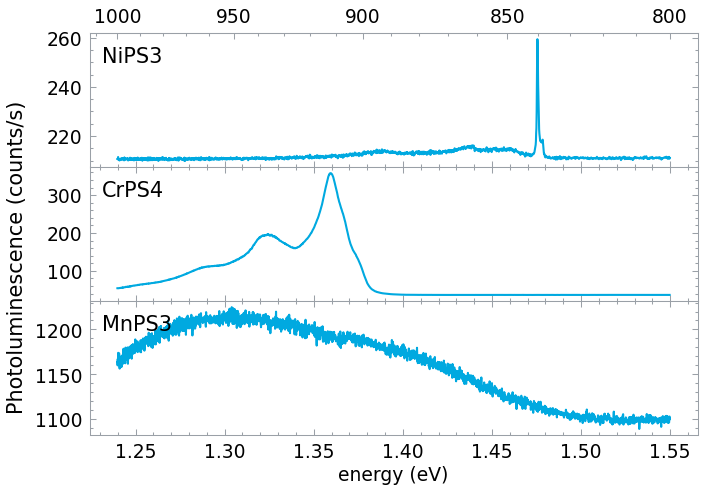

In [9]:
sel = [d for d in data if "CrPS4" == d.material and d.method == "luminescence" and "off" not in d.name]
sel = np.array(sel, dtype="object")[[1]]

sel_Mn = [d for d in data if "MnPS3" == d.material and d.method == "luminescence" and "off" not in d.name]
sel_Mn = np.array(sel_Mn, dtype="object")[[-1]]

sel_Ni = [d for d in data if d.material == "NiPS3" and d.method == "luminescence" and "off" not in d.name]
# sel_Ni = np.array(sel_Ni, dtype="object")[[1, 3]]
sel_Ni = np.array(sel_Ni, dtype="object")[[1]]

sel = np.concatenate((sel_Ni, sel, sel_Mn))
np.save("../selection/2023-12-10 PL.npy", sel, allow_pickle=True)

fig, axs = plt.subplots(len(sel), 1, sharex=True)

for i, (ax, d) in enumerate(zip(axs, sel)):
	s = d.sel(wavelength=slice(800, None))
	(
		# (s - s.min())/(s - s.min()).interp(wavelength=865)
		# (s - s.min())/(s - s.min()).max()
		s
	).assign_coords(energy=ev_to_nm(s.wavelength)).plot(
		label=d.material, ax = ax, _labels=False, x="energy"
	)
	# ax.set_ylabel(d.material, fontsize=FONTSIZE)
	ax.text(0.02, 0.9, d.material, transform=ax.transAxes, fontsize=FONTSIZE, verticalalignment='top')
	# ax.set_yticks([])

# fig.supylabel("Photoluminescence at 10K", fontsize=FONTSIZE)
axs[-1].set_xlabel("energy (eV)")

fig.supylabel("Photoluminescence (counts/s)", fontsize=FONTSIZE, x=0.05)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plot.energy_ticks(axs[0])



plt.savefig("../report/figures/2023-12-10 Combined PL.pdf")
plt.show()

In [24]:
sel.items()

dict_items([('CrPS4', [<xarray.DataArray '2023-10-31/d013_CrPS4_10K_lm_2x2s.asc' (wavelength: 5940)> Size: 48kB
array([210.75   , 210.75425, 210.81   , ..., 243.08325, 240.3855 ,
       237.353  ])
Coordinates:
  * wavelength  (wavelength) float64 48kB 530.0 530.1 530.2 ... 999.9 1e+03
    energy      (wavelength) float64 48kB 2.339 2.339 2.339 ... 1.24 1.24 1.24
Attributes:
    experiment:   13
    material:     CrPS4
    method:       luminescence
    capture:      2x2s
    temperature:  10.0
    angle:        None
    name:         2023-10-31/d013_CrPS4_10K_lm_2x2s.asc
    date:         2023-10-31 00:00:00
    remaining:    None
    path:         ../data/2023-10-31/d013_CrPS4_10K_lm_2x2s.asc
    number:       2
    exposure:     2.0, <xarray.DataArray '2023-11-07/d004_5x10s_CrPS_lm_onSample.asc' (wavelength: 5120)> Size: 41kB
array([36.58  , 36.4266, 36.3974, ..., 54.2268, 54.24  , 54.3344])
Coordinates:
  * wavelength  (wavelength) float64 41kB 560.0 560.1 560.2 ... 999.9 1e+03
   

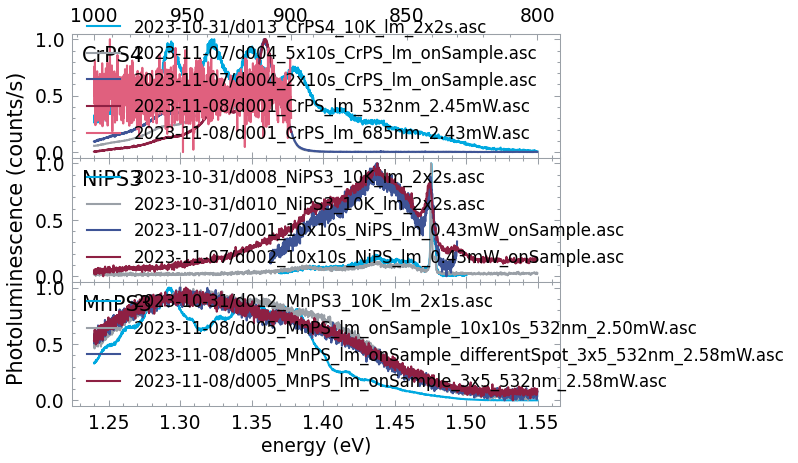

In [40]:
sel = [d for d in data if d.method == "luminescence" and "off" not in d.name and d.material]

sel = groupby_list(sel, lambda d: d.material)

sel = {
	"CrPS4": sel["CrPS4"],
	"NiPS3": sel["NiPS3"],
	"MnPS3": sel["MnPS3"],
}


fig, axs = plt.subplots(len(sel), 1, sharex=True)

for i, (ax, (mat, dat)) in enumerate(zip(axs, sel.items())):
	for d in dat:
		s = d.sel(wavelength=slice(800, None))
		# s=d
		(
			# (s - s.min())/(s - s.min()).interp(wavelength=865)
			(s - s.min())/(s - s.min()).max()
			# s
		).assign_coords(energy=ev_to_nm(s.wavelength)).plot(
			label=d.name, 
			ax = ax, _labels=False, x="energy"
		)
	# ax.set_ylabel(d.material, fontsize=FONTSIZE)
	ax.text(0.02, 0.9, d.material, transform=ax.transAxes, fontsize=FONTSIZE, verticalalignment='top')
	ax.legend(fontsize=FONTSIZE_TINY)
	# ax.set_yticks([])

# fig.supylabel("Photoluminescence at 10K", fontsize=FONTSIZE)
axs[-1].set_xlabel("energy (eV)")

fig.supylabel("Photoluminescence (counts/s)", fontsize=FONTSIZE, x=0.05)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plot.energy_ticks(axs[0])



# plt.savefig("../report/figures/2023-12-10 Combined PL.pdf")
plt.show()

## Reflection

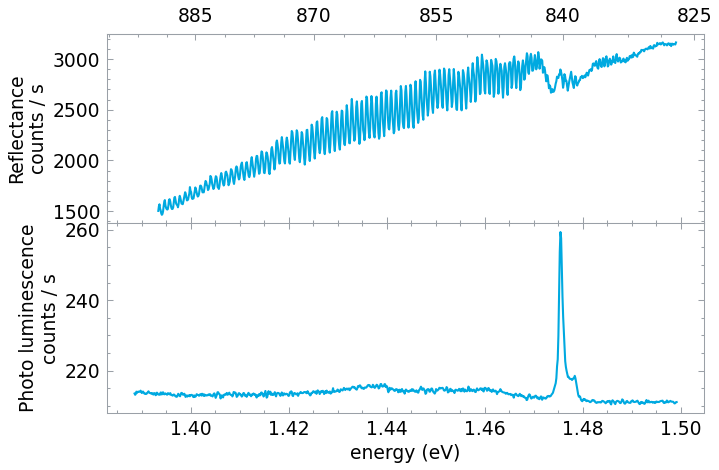

In [11]:
sel_pl = [d for d in data if "Ni" in d.name and d.method == "luminescence" and "off" not in d.name]
sel_refl = [d for d in data if "Ni" in d.name and d.method == "reflectance" and "off" not in d.name and "dark" not in d.name]

fig, axs = plt.subplots(2, 1, sharex=True)

wl_sel = slice(830-3, 890+3)

sel_refl[2].sel(wavelength=wl_sel).plot(ax=axs[0], _labels=False, x="energy")
axs[0].set_ylabel("Reflectance\ncounts / s")

sel_pl[1].sel(wavelength=wl_sel).plot(ax=axs[1], _labels=False, x="energy")
axs[1].set_ylabel("Photo luminescence\ncounts / s")

plot.energy_ticks(axs[0])
axs[1].set_xlabel("energy (eV)")

plot.hide_inner_label()

# plt.xlim(wl_sel.start, wl_sel.stop)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("../report/figures/2024-02-06 NiPS3 PL and reflectance.pdf")
plt.show()